# FFT简明笔记

## 1. 傅立叶变换

变换的本质是从不同的角度解读同样的事物。对于时序上的数据，我们可以通过每个时刻点获得的数据来描述，但这样做的效率不是很高，因为我们需要获取一堆的数据才能描述一个事物，不仅耗费存储，还不直观，但能否构造一个方法，从这些数据中提取有用的信息来减少我们的负担呢？答案就是傅立叶变换。傅里叶变换是一种线性的积分变换，它来自于数学家们对于傅立叶级数的研究。我们知道任何函数都能写成傅立叶级数的表达方式，也就是：

$$f(x) = a_0+\sum_{n=1}^{+\infty}\left[a_n\cos(nx)+b_n\sin(nx)\right]$$

那么一个信号在时域（或空域）和频域之间就会存在一些对应关系，通过这个关系，我们就可以将一个信号从一种表示转换成另一种表示，而在某些情况下，这种利用频率的表示方法（频域）比时域更直观，因而傅立叶变换在很多工程领域如通信、加密、金融、信号处理中有着重要作用。

在进入傅立叶变换之前，我们先介绍下信号的特征组成：

利用信号的周期性特征，我们可以把信号分成周期信号和非周期信号，虽然非周期信号也可以用傅立叶变换表达，但我们这里仅讨论周期信号。如果一个信号$y(t)$满足$y(t)=y(t+T)$对任何时刻都成立，那么该信号是周期信号，且周期为$T$。

周期信号大致上由两部分组成，一个是直流部分（DC），该部分大小等于信号的平均值：

$$DC=a_0=\frac{1}{T}\int_{-T/2}^{T/2}y(t)dt$$

一个是交流部分（AC），该部分则是信号扣除直流剩下的分量。我们可以发现交流部分均值为0，且具有周期性，那么交流部分通过若干简谐波进行叠加，完全可以对其实施替代。根据傅立叶的研究，这个级数的系数为：（其中$\omega = 2\pi/T = 2\pi f$）

$$a_n = \frac{2}{T}\int_{-T/2}^{T/2}y(t)\cos(\omega nt)dt$$
$$b_n = \frac{2}{T}\int_{-T/2}^{T/2}y(t)\sin(\omega nt)dt$$

这样任何周期函数就都能通过傅立叶级数进行近似了。

［案例1］某锯形波函数如下所示，试求出其分量振幅：
$$y(t)=\left\{\begin{array}{ll}1&(0+2k\pi<t\leqslant\pi+2k\pi;k\in\mathbb{Z})\\ 0& (-\pi+2k\pi<t\leqslant2k\pi;k\in\mathbb{Z})\end{array}\right.$$
**解答**：很显然该锯形波的直流分量为0.5。由于该锯形波交流部分为奇函数，我们无需求其余弦分量大小即可知$a_n=0$。现求其正弦分量：
$$b_n=\frac{1}{\pi}\int_{0}^{\pi}sin(nt)dt=\frac{1}{n\pi}\int_{0}^{n\pi}\sin(t)dt=\frac{1}{n\pi}(1-\cos(n\pi))$$
因此：
$$b_n=\frac{1}{n\pi}(1-\cos(n\pi))$$

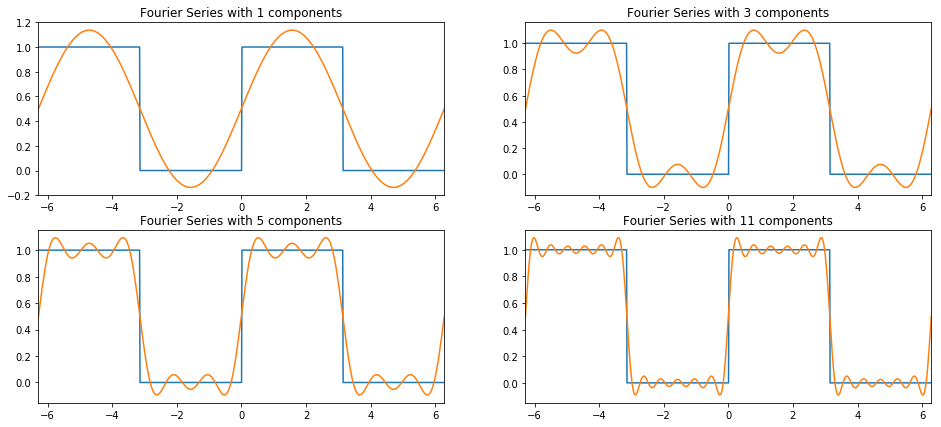

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 7.0) # set default size of plots

fig,axes = plt.subplots(nrows=2,ncols=2)
ii = 0

t = np.linspace(-2*np.pi,2*np.pi,1000)
y = np.zeros(1000)
y[0:250]=1
y[501:750]=1
yf = 0.5  # DC part of signal
for n in range(1,12):
    b = (1-np.cos(n*np.pi))/(np.pi*n)
    yf += b*np.sin(n*t)    # n-th AC component
    if n in [1, 3, 5, 11]:
        plt.sca(axes[ii/2][ii%2]); ii+=1
        plt.plot(t,y); plt.plot(t,yf)
        plt.xlim(-2*np.pi,2*np.pi)
        plt.title("Fourier Series with %d components"%n)
plt.show()

当然，如果用正弦和余弦函数表示显然还是不够简洁，我们可以通过欧拉公式$e^{j\phi}=\cos(\phi)+j\sin(\phi)$将傅立叶变换（时域到频域）简写成：

$$Y(\omega)=\frac{1}{2\pi}\int_{-\infty}^{+\infty}y(t)e^{-j\omega t}dt$$

当然了，其逆变换（频域到时域）则是：

$$y(t)=\int_{-\infty}^{+\infty}Y(\omega)e^{j\omega t}d\omega$$

这样$Y(\omega)$便成了与信号分量的频率有关的一个复变函数，其复数的模量为信号的振幅，相位为信号的相位，这两个特征又被称为频谱和相位谱。在接下来的部分，你将看到这两个特征将如何简化我们描述信号。

## 2. 信号离散

人们提到傅立叶变换，一般指的是连续变换，但在实际环境下，我们并不能进行连续分析，因为：

- 我们采样手段和数据存储方式决定了我们的样本只能是离散的；

- 即便我们可以连续采样，这样样本所需存储的占用会非常巨大，而我们不一定能有这么多空间存储数据。

因此事实上，人们是对实际连续信号，通常会进行采样，进行离散化。而在实施中就必然会面对一个问题，我们要多少数据？如果每次采样时间间隔短，则样本将越接近真实输入信号，但无可避免的，会占用更多存储，如果采样时间间隔长，虽然可以减少空间占用，但又会因为遗漏掉信息，导致无法准确描述输入信号。因此采样的时间间隔对于信号离散化是一个很重要的参数，通常我们取其倒数，称为采样频率 $f_s=1/\Delta T$。

［案例2］试对函数$y=3\sin(2\pi t)+\cos(20\pi t)$用不同频率进行采样：

**解答**：以上信号由两个分量组成：一个分量频率为1振幅为3，一个分量频率为10，振幅为1。我们现在用4个不同的采样频率来对其采样。

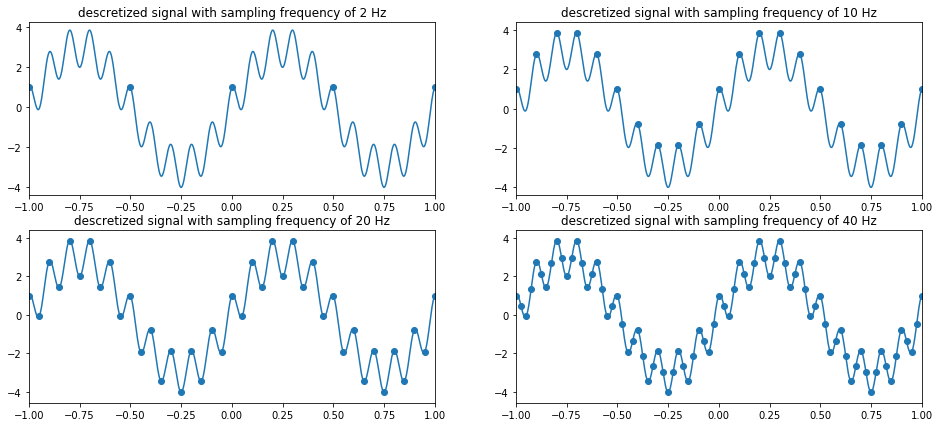

In [2]:
fig,axes = plt.subplots(nrows=2,ncols=2)

t = np.linspace(-1,1,1000)

y = lambda t: 3*np.sin(2*np.pi*t) + np.cos(20*np.pi*t)

for i,f in [(0,2),(1,10),(2,20),(3,40)]:
    plt.sca(axes[i/2][i%2]);
    ts = np.linspace(-1,1,2*f+1)
    plt.plot(t,y(t))
    plt.scatter(ts,y(ts))
    plt.xlim(-1,1)
    plt.title("descretized signal with sampling frequency of %d Hz"%f)
plt.show()

从上图我们可以看到在采样频率小于等于2Hz的时候，所得到的信息严重不足，不足以重建原函数，而在采样频率小于10Hz时，我们能够从采样点中大致看到低频信号，但无从得知高频部分的信息；在采样频率增加到20Hz时，我们终于拥有了足够的信息重建原函数；而大于20Hz，虽然我们能够准确描述原函数了，但由于采样点也更多了，因此存储的耗费也会更大。从这几个关键点看来，我们能够得知有一个采样频率，能使得我们的采样点不会过多，也不会导致离散信号失真。而为了找到这样的一个临界点，我们需要了解一点**Nyquist采样定理**。

## 3. 信号失真（Aliasing）与Nyquist采样定理

从上面的结果，我们可以看到，如果采样频率过低，我们是无法对原信号进行重建的。而且重建得到的信号与原信号之间会存在一些多出来的部分，这些部分通常会以低频分量表现出来（比如上图10Hz采样中重构信号的DC部分变成了1），而这是在原信号中所没有的，这被称之为信号失真（Aliasing），或者称为伪频率。美国电信工程师Nyquist进过研究发现，**当采样频率大于信号分量中最高频率的两倍时，信号不会发生失真**，该定理称之为Nyquist采样定理。比如一个信号由若干频率的分量组成，而其中最大的频率为10Hz，则我们用大于20Hz对其采样，便不会发生失真。反过来，如果的传感器采样频率一定，则能够准确采集的信号频率范围则小于它的一半，这个值被称为**Nyquist频率**。比如某录音机的采样频率为120KHz，则其能准确采集的信号范围为0-60KHz，其他频率的信号将会失真，以伪频率的形式呈现。

［案例3］如果一个简谐波$y(t)=\sin(5\pi t)$用2Hz进行采样，我们通过Nyquist定理，知道这个离散信号会失真，那么它会被重建成什么信号呢？

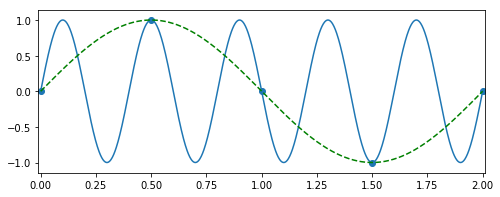

In [3]:
plt.rcParams['figure.figsize'] = (8.0, 3.0)

y = lambda t:np.sin(5*np.pi*t)
yn = lambda t:np.sin(np.pi*t)
t = np.linspace(0,2,1000)
ts = np.linspace(0,2,5)
plt.xlim(-0.01,2.01)
plt.plot(t,y(t))
plt.scatter(ts,y(ts))
plt.plot(t,yn(t),'g--')
plt.show()

可以看到，由于采样不充分，通过离散信号得到的重建函数为$y(t)=\sin(\pi t)$，而非$y(t)=\sin(5\pi t)$。也就是说原频率为2.5Hz的信号通过2Hz的采样，被重建成了0.5Hz的信号。而对于一般采样过程，如果采样频率为 $f_s$，目标频率为 $f$，则采集到的“实际”频率为

$$f_a=\left|\text{round}\left(\frac{f}{f_s}\right)\times fs-f\right|$$

［案例4］如果利用 $f_s=2$Hz的采样频率采集 $f=2.5$Hz的信号，得到的离散信号频率为多少？

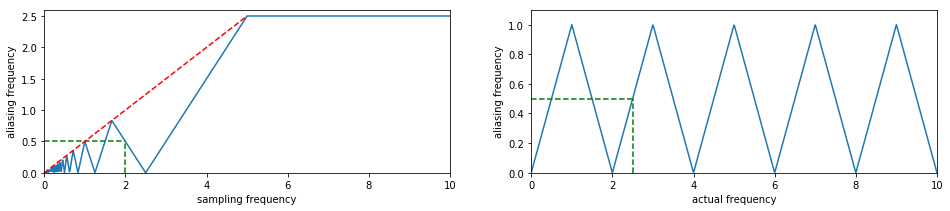

In [4]:
plt.rcParams['figure.figsize'] = (16.0, 3.0)

plt.subplot(121)
f = 2.5; fs = np.linspace(0.00000001,10,1000) # to avoid invalid division
plt.plot(fs,np.abs(np.round(f/fs)*fs-f))
plt.plot([2,2],[0,0.5],'g--');plt.plot([0,2],[0.5,0.5],'g--')
plt.plot([0,5],[0,2.5],'r--')
plt.xlim(0,10); plt.ylim(0,2.6)
plt.xlabel("sampling frequency"); plt.ylabel("aliasing frequency")
plt.subplot(122)
fs = 2; f = np.linspace(0,10,1000)
plt.plot(f,np.abs(np.round(f/fs)*fs-f))
plt.plot([2.5,2.5],[0,0.5],'g--');plt.plot([0,2.5],[0.5,0.5],'g--')
plt.xlim(0,10); plt.ylim(0,1.1)
plt.xlabel("actual frequency"); plt.ylabel("aliasing frequency")
plt.show()

## 4. DFT－离散傅立叶变换

有了以上基础，我们简单来看一下离散信号的傅立叶变换，我们知道一般傅立叶变换运用在连续信号上，但这并不意味着离散信号无非使用傅立叶变换。通过对原表达式进行细小的改变，我们即可得到离散傅立叶变换的表达式：

$$y(m\Delta t)=\sum_{n=0}^{N-1}C_ne^{j2\pi nm/N}$$

其中：

$$C_n=\frac{1}{N}\sum_{m=0}^{N-1}y(m\Delta t)e^{j2\pi nm/N}$$

从上式可以看到如果离散信号有N个点，那么我们就可以相应计算出信号中的N个分量。如果我们花了$t$时间采集的$N$个点，那么采样频率则为$f_s＝1/\Delta t=N/t$，上式又可以改写为：

$$y(m\Delta t)=\sum_{n=0}^{N-1}C_ne^{j2\pi (n/t)m\Delta t}$$

因为离散后的时间为$m\Delta t$，$C_n$仅描述相位和振幅，因此通过后半部分，我们可以得知这N个分量的频率是$n/t=n\frac{f_s}{N}=n\Delta f$。故傅立叶变换的频域空间为从0Hz到采样频率 $f_s$的N个离散点。而我们从Nyquist定理知道，超过Nyquist频率的信号都会出现失真。因此事实上大于$f_s/2$的这一部分，会通过伪频率$f_a=f-fs$的形式反映到结果中。（由于$f-f_s<0$，我们可以通过调整相位使得频率大于0）

换言之，通过DFT，我们可以将定义在 $\{n\times\Delta t\};n=1\dots N$ 时域上的信号用定义在 $\{m\times\Delta f\};m=1\dots N/2$ 频域上的频谱来描述。

## 5. FFT－快速傅立叶变换

通过上面我们已经知道了如何将离散的时域信号转换到频域上，但有一个很严肃的问题出现了，如果按照以上过程计算，每一个系数的计算时间和信号长度成正比，也就是$O(N)$；而我们有N个这样的系数要计算，因此，如果不加优化将会耗费$O(N^2)$的时间。对于高频率采样的信号来说，这样的计算强度无疑是一个灾难。而幸好该问题有一个比较高效的解答，那就是**Cooley-Tukey算法**，运用该算法，计算时间只用耗费$O(N\log(N))$的时间。而这在信号采样点数量庞大时将会有很明显的优势。对于其计算原理，这里便省略了，如果有兴趣可以参考 [Fast Fourier Transformation - Wikipedia](https://en.wikipedia.org/wiki/Fast_Fourier_transform)。这里仅介绍其应用的实例。

［案例5］信号$y=3\sin(2\pi t)+\cos(20\pi t)$（同案例2）被不同采样频率采样得到的频谱有何差别？

**注意**：我们可以利用`numpy.fft.fft(a)`进行快速傅立叶变换。

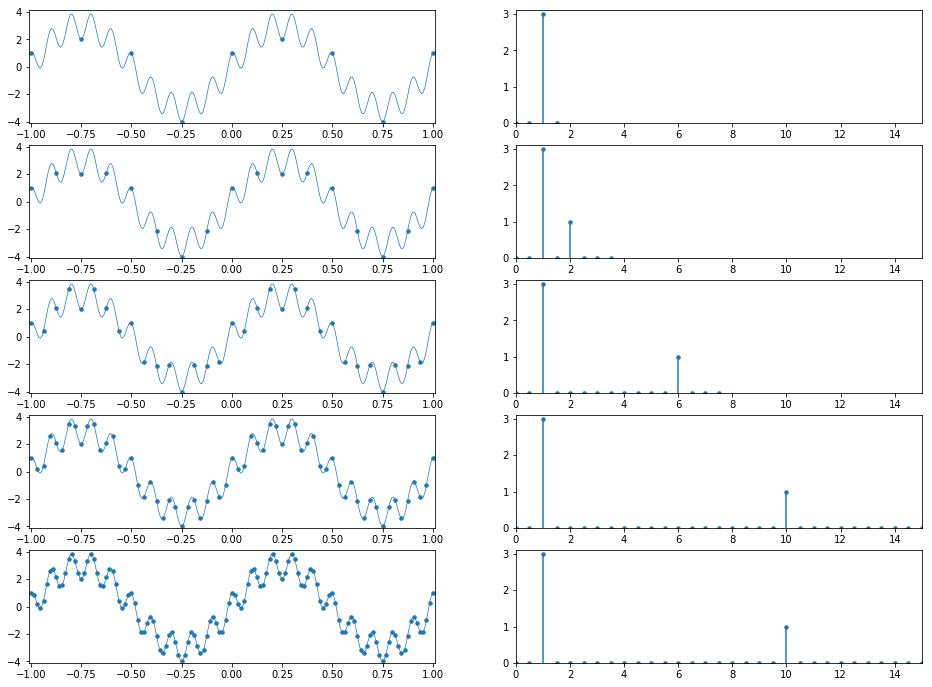

In [5]:
from numpy.fft import fft
plt.rcParams['figure.figsize'] = (16.0, 12.0)

y = lambda t: 3*np.sin(2*np.pi*t) + np.cos(20*np.pi*t)
t = np.linspace(-1,1,256)

fig, axes = plt.subplots(nrows=5,ncols=2)
for i in range(5):
    N=[8,16,32,64,128][i]
    plt.sca(axes[i][0])
    ts = np.linspace(-1,1,N+1)
    plt.plot(t,y(t),lw=0.7)
    plt.scatter(ts,y(ts),s=12)
    plt.xlim(-1.01,1.01);plt.ylim(-4.1,4.1)
    
    
    plt.sca(axes[i][1])
    fs = N/2.; f = np.linspace(0,fs,N+1)
    plt.xlim(0,15);plt.ylim(0,3.1)
    yf = np.abs(fft(y(ts[:-1])))*(2./N)
    
    plt.scatter(f[:N/2],yf[:N/2],s=12)
    for i in xrange(N/2):
        plt.plot([f[i],f[i]], [0,yf[i]], color='tab:blue', linestyle='-')

plt.show()

从上图可以看到随着采样点数目的不断增加，FFT的计算结果越来越接近真实值，也就是主频1Hz和10Hz，振幅分别为3和1。我们通过计算可以得到这几个的频率分别是4Hz，8Hz，16Hz，32Hz和64Hz。由于1Hz的分量只需要大于2Hz的采样频率，因此因此1Hz的主频可以被测定，但10Hz的成分必须要20Hz以上的采样频率才能测定，因此，前三个采样无法获取信号中的高频部分，而后两个因为小于Nyquist频率，可以获取高频部分。

## 6. FFT使用注意事项

FFT的分析结果除了和分量最大频率、采样频率有关，还和采样的时长有一定关系，我们知道由于我们不可能无限制的进行采样，因此拿到手上的信号一定只是其中的一部分，而我们默认原信号可以用该离散点不断重复获得，当截取长度为周期的倍数时，可能还没什么关系，但如果截取长度不为周期的倍数，就意味着有一段多出来的部分，而这一部分原本应该被视为周期内部的一段，而由于截取不当，却被当作了单独的段落。这样在计算时，会导致频谱发生改变，如下实例所示：

［实例6］对于简谐波$y=\sin(2\pi t)$我们分别用10Hz采集1秒、1.25秒、1.5秒、1.75秒和2秒，其频谱如何分布？

**注释**：10Hz相当于间隔时间$\Delta T=0.1$s。

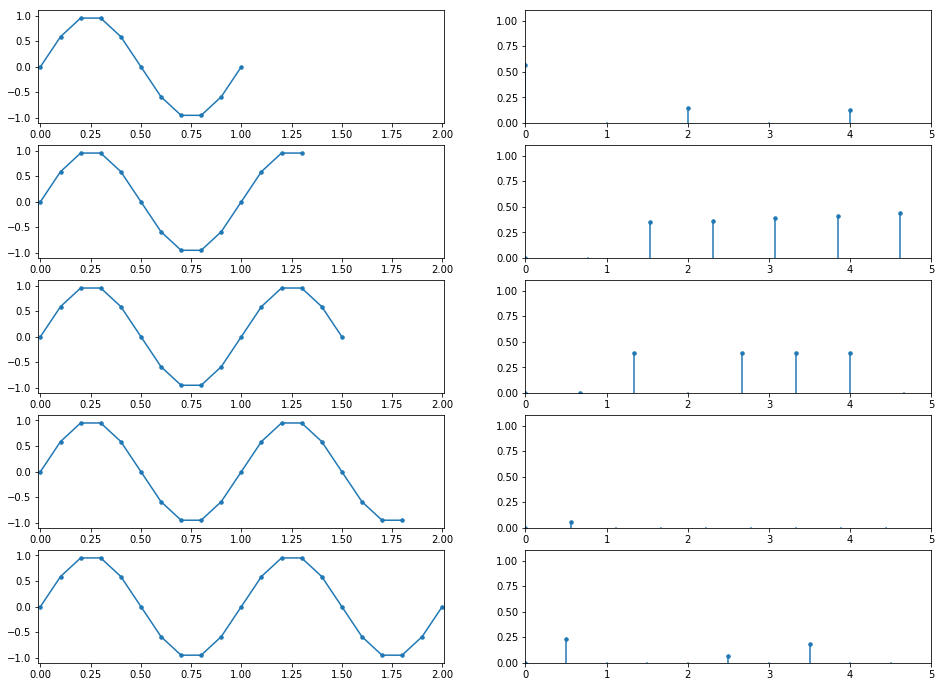

In [9]:
from numpy.fft import fft
plt.rcParams['figure.figsize'] = (16.0, 12.0)

y = lambda t: np.sin(2*np.pi*t)

fig, axes = plt.subplots(nrows=5,ncols=2)
for i in range(5):
    T = [1,1.25,1.5,1.75,2][i]
    t = np.arange(0,T+0.1,0.1)

    plt.sca(axes[i][0])
    plt.plot(t,y(t))
    plt.scatter(t,y(t),s=12)
    plt.xlim(-0.01,2.01),plt.ylim(-1.1,1.1)
    
    N = t.shape[0]
    plt.sca(axes[i][1])
    fs = 10.; f = np.linspace(0,10,N)
    plt.xlim(0,5);plt.ylim(0,1.1)
    yf = np.angle(fft(y(t[:-1])))*(2./N)
    
    plt.scatter(f[:N/2],yf[:N/2],s=12)
    for i in xrange(N/2):
        plt.plot([f[i],f[i]], [0,yf[i]], color='tab:blue', linestyle='-')

plt.show()

可以看到虽然都是1Hz的信号，但由于截取长度不一，其频谱有着很大的变化，值得注意的就是周期截取的计算结果符合事实，而非周期截取则和事实有所偏差。首先在非周期的截取中，信号的直流部分发生了改变，这是显而易见的，因为原始信号一个周期的平均值为0，当截取不足一个周期时，其平均值就会有所偏离，从而产生信号中有直流部分的错觉。其次就是主频的振幅有所下降，取而代之的是主频周围的频率振幅有所上升。（我们可以认为是非周期截取使得主频的振幅被分配到了周边频率以刻画非周期片段）这种现象称之为**频谱泄露**。频谱泄露是采样中无可避免的问题，但我们可以通过窗函数来减小它带来的影响。（见后文述）

## 7. 再谈伪频和滤波

从Nyquist采样定理我们知道，超过Nyquist频率的信号将会失真，我们得到的也不过是伪频。而现实生活中却存在着很多高频噪音，这样的话，对于我们的采样会有很大的影响。我们先来看一个例子：

［案例7］试用5Hz的采样频率对信号$y=3\sin(2\pi t)+\cos(20\pi t)$进行采样，并利用频谱／相位谱信息对其进行重建。

**注意**：这里我们最好取一个完整周期以避免频谱泄露的影响。

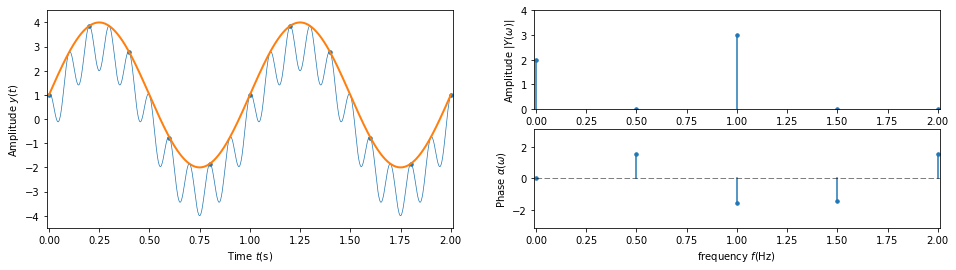

In [7]:
from numpy.fft import fft
plt.rcParams['figure.figsize'] = (16.0, 4.0)

fs = 5; DeltaT = 1./fs

y = lambda t: 3*np.sin(2*np.pi*t) + np.cos(20*np.pi*t)

ts = np.arange(0,2+DeltaT,DeltaT)
t = np.linspace(0,2,1000)
N = ts.shape[0]-1
f = np.linspace(0,fs,N+1)

plt.subplot2grid((2,2),(0,1))
yf = np.abs(fft(y(ts[:-1])))*(2./N)
plt.scatter(f[:N/2],yf[:N/2],s=12)
for i in xrange(N/2):
    plt.plot([f[i],f[i]], [0,yf[i]], color='tab:blue', linestyle='-')
plt.xlim(-0.01,fs/2+0.01);plt.ylim(0,4)
plt.ylabel(r"Amplitude $|Y(\omega)|$")

plt.subplot2grid((2,2),(1,1))
af = np.angle(fft(y(ts[:-1])))
plt.scatter(f[:N/2],af[:N/2],s=12)
for i in xrange(N/2):
    plt.plot([f[i],f[i]], [0,af[i]], color='tab:blue', linestyle='-')
plt.plot([0,5],[0,0],'k--',lw=0.5)
plt.xlim(-0.01,fs/2+0.01);plt.ylim(-np.pi,np.pi)
plt.ylabel(r"Phase $\alpha(\omega)$")
plt.xlabel(r"frequency $f$(Hz)")

plt.subplot2grid((2,2),(0,0),rowspan=2)
plt.plot(t,y(t),lw=0.7)
plt.scatter(ts,y(ts),s=12)
yr = np.ones_like(t) * (yf[0]/2.)
for i in range(1,N/2):
    ff = f[i]
    aa = yf[i]
    pp = af[i]
    yr += aa*np.cos(2*np.pi*ff*t + pp)
plt.plot(t,yr,lw=2)

plt.xlim(-0.01,2.01);plt.ylim(-4.5,4.5)
plt.xlabel(r"Time $t$(s)")
plt.ylabel(r"Amplitude $y(t)$")

plt.show()

从上图可以看到，虽然我们重构了信号，而且发现了1Hz的主频，但由于信号失真，10Hz的信号在5Hz的采样过程中被“表达”成了大小为1的DC分量（直流分量的振幅为分量大小的两倍，这是在傅立叶级数中定义的 $a_0=2*DC$）这样，如果我们关心的是低频信号，由于信号失真导致的伪频率会对我们的分析结果产生很重大的影响。因此，在采集信号时我们应当对信号进行过滤：如果高频噪音被减弱，则失真也会相应减弱。

对于高频噪音，通常有两种方法进行过滤：
- 保持低频采样，同时运用电路特性减弱高频信号。
- 通过高频率采样，获得足够多数据点，然后进行加窗操作过滤高频噪音。

这两种方法实际操作中都运用的到，但要注意的是由于失真发生在采样过程中，只要采样完成，信号就一定或多或少有失真。因此，如果我们想通过加窗操作来过滤低频采样中的高频信号，是不可能的；因为在采样完成后，由于采样点数量不足，高频信号被混淆成了低频信号，这时再加窗，窗函数对“伪低频信号”的过滤能力就很有限了。因此以上两种操作，要么是在采样前就减弱高频噪音，要么是通过高频采样获取高频噪音，然后减弱它。

### 7.1 滤波电路

假定某信号可以通过传感器转换成电压信号$u(t)$，为了在采样前就能够减弱某个范围内的信号，我们可以构建如下电路：
- 将电阻R和电感L串联，并让电阻输出信号$u^1_{out}$；
- 将电阻R和电容C串联，并让电阻输出信号$u^2_{out}$。

因为电阻，电容，电感的电抗分别为$R$、$\frac{1}{j\omega C}$、$j\omega L$。则两个电路内的电流分别为
$$\dot I_1= \dot U/(R+j\omega L)$$
$$\dot I_2= \dot U/(R+\frac{1}{j\omega C})$$
而分配到电阻上的电压分别是：
$$\dot U_1= R/(R+j\omega L)\dot U$$
$$\dot U_2= R/(R+\frac{1}{j\omega C})\dot U$$
仅考虑幅值，可以看到
$$|\dot U_1|= \frac{1}{\sqrt{1+(\frac{\omega L}{R})^2}}|\dot U|$$
$$|\dot U_2|= \frac{1}{\sqrt{1+(\frac{1}{\omega CR})^2}}|\dot U|$$
随着角频率$\omega$的不断变大，$|\dot U_1|$会不断变小，而$|\dot U_2|$会不断变大；这个性质就可以被我们利用从而实现滤波。前一个由于随着频率增加，振幅不断减小，可以用于滤除高频成分；而后一个正相反，可以用于滤除低频成分。值得注意的是，虽然这个方法可以让我们用较低的采样频率，但考虑到滤波电路会对相位产生影响，因此，滤波后的函数仍然会有一定失真（相位上）。

### 7.2 窗函数

#### A. 移动平均窗

由于通常我们遇到的是高频噪音，而它们通常对应于短时间的变化量，如果我们将某一段进行平均，则可以将这种短时随机变化进行补偿，从而减小该成分。如果窗越长，越多的数据点会参与计算，从而能消除更多的变化。

［案例9］对信号$y(t) = \sin(5t) + \cos(25t)$用100Hz进行采样，并用不同窗长进行平均，试求窗长和频谱的关系。

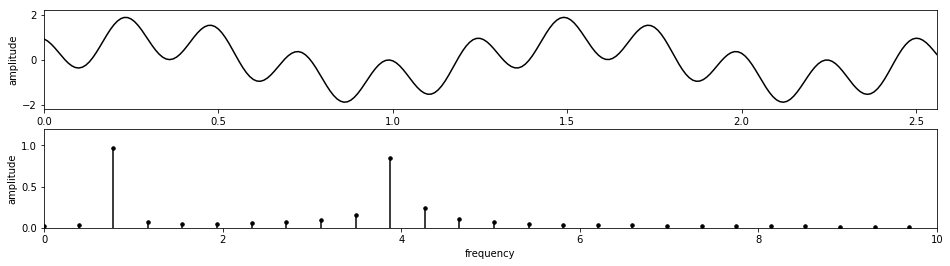

In [8]:
def pltSin(y,t):
    xf = np.linspace(0, 1/dt/2, N/2)
    fy = np.fft.fft(y)
    plt.subplot(211)
    plt.plot(t,y,'k-')
    plt.xlabel("time")
    plt.ylabel("amplitude")
    plt.xlim(0,t[-1])
    plt.ylim(-2.2,2.2)
    plt.subplot(212)

    fy = (2./N)*np.abs(fy[0:N/2])
    plt.scatter(xf, fy, s=12, c='k')
    for i in range(xf.shape[0]):
        xx = xf[i]
        yy = fy[i]
        plt.plot([xx,xx],[0,yy],'k-')
    plt.xlim(0,10)
    plt.ylim(0,1.2)
    plt.xlabel("frequency")
    plt.ylabel("amplitude")
    plt.show()

w = 5
N = 256+w
dt = 0.01
t = np.arange(N)*dt
y = np.sin(5*t) + np.cos(25*t)
ys = np.zeros(N-w+1)
for i in range(N-w+1):
    ys[i] = np.mean(y[i:i+w])
pltSin(ys, t[:N-w+1])

#### B.

## 8. FFT应用：音阶分析

空气的周期性压缩与膨胀产生声音，不同的声音由其频率特性所决定，而在音乐中，不同的音阶的本质就是声音的频率差别，比如

根据以上描述，我们可以知道，